# PixelCNN

In [22]:
# import matplotlib.pyplot as plt

# import torch
# from torch import nn, optim
# from torch.utils.data import DataLoader

# import torchvision
# import torchvision.transforms as T

In [23]:
# # parameters from the paper
# batch_size = 16
# num_layers = 7
# num_channels = 32

# # other parameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# lr = 0.001
# num_epochs = 10

The architecture is designed for MNIST only and for static inputs.

In [24]:
# architecture
# 1. 7 x 7 with conv mask A
# 2. stack 3 x 3 with conv mask B
# 3. ReLU + 1x1 conv layer with mask B (2 layers)
# 4. 256 Ways softmax

In [25]:
# # Type A or B masked Conv2d 
# class MaskedConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, mask='A'): 
#         super().__init__()
#         # calculate the padding automatically 
#         # so that input width+height dims = output dims
#         padding = int((kernel_size - 1) / 2)
        
#         self.conv = nn.Conv2d(in_channels=in_channels,
#                              out_channels=out_channels,
#                              kernel_size=kernel_size,
#                              padding=padding)
        
#         # calculate masks A or B as in the original paper
#         mask_idxs = torch.arange(0, kernel_size**2).view(kernel_size, kernel_size)
#         if mask == 'A':
#             mask = (mask_idxs < padding * kernel_size + padding).float().to(device)
#         elif mask == 'B':
#             mask = (mask_idxs <= padding * kernel_size + padding).float().to(device)
#         self.register_buffer('mask', mask)
            
#     def forward(self, x):
#         # apply mask, see below link for more info
#         # https://discuss.pytorch.org/t/applying-custom-mask-on-kernel-for-cnn/87099
        
#         with torch.no_grad():
#             self.conv.weight = nn.Parameter(self.conv.weight * self.mask)
#         return self.conv(x)

In [26]:
# test2dLayer = MaskedConv2d(in_channels=1, out_channels=num_channels, kernel_size=7).to(device)
# testdata = torch.randn(1, 1, 28, 28, device=device)
# test2dLayer(testdata).shape

In [27]:
# class PixelCNN(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.layers = nn.Sequential(
#                 MaskedConv2d(in_channels=1, out_channels=num_channels, kernel_size=7, mask='A'), 
#                 nn.ReLU(),
#                 MaskedConv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, mask='B'), 
#                 nn.ReLU(),
#                 MaskedConv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, mask='B'), 
#                 nn.ReLU(),
#                 nn.Conv2d(num_channels, num_channels*2, kernel_size=1),
#                 nn.ReLU(),
#                 nn.Conv2d(num_channels*2, 1, kernel_size=1)
#         )
    
#     def forward(self, x):
#         return self.layers(x)

In [28]:
# test_images = torch.randn(batch_size, 1, 28, 28, device=device)
# model = PixelCNN().to(device)
# model(test_images).shape

In [29]:
# train_dataset = torchvision.datasets.MNIST(root='../datasets/', 
#                                            train=True, 
#                                            transform=T.ToTensor(), 
#                                            download=True)

# test_dataset = torchvision.datasets.MNIST(root='../datasets/', 
#                                            train=False, 
#                                            transform=T.ToTensor(), 
#                                            download=False)

In [30]:
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

In [31]:
# model = PixelCNN().to(device)
# # mse would most likely also work
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters())

In [32]:
# def train():
#     for epoch in range(1, num_epochs+1):
#         train_loss = []
#         for features, _ in train_dataloader:
#             features = features.to(device)
#             logits = model(features)
#             loss = criterion(logits, features)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             train_loss.append(loss.cpu().item())
        
#         print(f'Epoch: {epoch}/{num_epochs}, Loss: {sum(train_loss)/len(train_loss)}')

In [33]:
# train()

In [34]:
# # test the reconstruction by comparing original images with the reconstructed images
# with torch.inference_mode():
#     for idx in range(5):
#         image, _ = test_dataset[idx]
#         image = image.unsqueeze(0)
#         generated_image = model(image.to(device))
#         generated_image = torch.sigmoid(generated_image)
#         generated_image = generated_image.squeeze()

#         plt.subplot(1, 2, 1)
#         plt.imshow(image.squeeze(), cmap="gray")
#         plt.title("Original")
#         plt.axis("off")

#         plt.subplot(1, 2, 2)
#         plt.imshow(generated_image.cpu(), cmap="gray")
#         plt.title("Reconstructed")
#         plt.axis("off")
#         plt.show()

In [35]:
# image, _ = test_dataset[0]
# image = image.squeeze()
# for row_idx, row in enumerate(image):
#     for col_idx, _ in enumerate(image):
#         if row_idx >= 14:
#             image[row_idx][col_idx] = 0
# plt.imshow(image.squeeze())

In [36]:
# image, _ = test_dataset[0]
# image = image.squeeze()
# for row_idx, row in enumerate(image):
#     for col_idx, _ in enumerate(image):
#         if row_idx >= 14:
#             image[row_idx][col_idx] = 0

# image = image.unsqueeze(0).unsqueeze(0).to(device) 
# with torch.inference_mode():
#     for row_idx in range(28):
#         for col_idx in range(28):
#             generated_image = model(image)
#             generated_image = torch.sigmoid(generated_image)
#             generated_image = generated_image.squeeze()
#             if row_idx >=14:
#                 image[0][0][row_idx][col_idx] = generated_image[row_idx][col_idx]
            
# plt.imshow(image.cpu().squeeze(), cmap="gray")
# plt.title("Reconstructed")
# plt.axis("off")
# plt.show()


## PixelCNN with Gated Convolutions

This part is highly inspired by [uvadlc-notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial12/Autoregressive_Image_Modeling.html)

In [37]:
!nvidia-smi

Fri Oct 21 11:31:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    614MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
import time
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

In [39]:
## hyperparameters
NUM_EPOCHS = 50
BATCH_SIZE = 128
NUM_CHANNELS = 64
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
def discretize(sample):
    return (sample * 255).to(torch.long)

transform = T.Compose([T.ToTensor(),
                        discretize])


train_dataset = MNIST(root='../datasets/', train=True, download=True, transform=transform)
test_dataset = MNIST(root='../datasets/', train=False, download=False, transform=transform)

In [41]:
train_dataloader = data.DataLoader(dataset=train_dataset, 
                                   batch_size=BATCH_SIZE, 
                                   shuffle=True, 
                                   num_workers=2,
                                   drop_last=True,
                                   pin_memory=True)
test_dataloader = data.DataLoader(dataset=test_dataset, 
                                   batch_size=BATCH_SIZE, 
                                   shuffle=True, 
                                   num_workers=2)

In [42]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, in_channels, out_channels, mask, dilation=1):
        super().__init__()
        kernel_size = mask.shape
        padding = tuple([dilation * (size-1)//2 for size in kernel_size])
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=kernel_size,
                              padding=padding,
                              dilation=dilation)
        
        self.register_buffer('mask', mask)
    
    def forward(self, x):
        with torch.no_grad():
            self.conv.weight = nn.Parameter(self.conv.weight * self.mask)
        return self.conv(x)

In [43]:
mask = torch.rand(3, 3)
img = torch.randn(1, 1, 28, 28)
mask_conv = MaskedConvolution(1, 32, mask, dilation=2)
mask_conv(img).shape

torch.Size([1, 32, 28, 28])

In [44]:
class VerticalStackConvolution(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_type='B', dilation=1):
        assert mask_type in ['A', 'B']
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        if mask_type=='A':
            mask[kernel_size//2,:] = 0
        
        super().__init__(in_channels, out_channels, mask, dilation=dilation)
        
class HorizontalStackConvolution(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_type='B', dilation=1):
        assert mask_type in ['A', 'B']
        mask = torch.ones(1, kernel_size)
        mask[0, kernel_size//2+1:] = 0
        if mask_type=='A':
            mask[0, kernel_size//2] = 0
        super().__init__(in_channels, out_channels, mask, dilation=dilation)

In [45]:
test = VerticalStackConvolution(1, 32, 3)
print(test.mask)
test = VerticalStackConvolution(1, 32, 3, 'A')
print(test.mask)
test = HorizontalStackConvolution(1, 32, 3)
print(test.mask)
test = HorizontalStackConvolution(1, 32, 3, 'A')
print(test.mask)
del test

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 0.]])
tensor([[1., 0., 0.]])


In [46]:
class GatedConvolution(nn.Module):
    def __init__(self, in_channels, kernel_size=3, dilation=1):
        super().__init__()
        self.v = VerticalStackConvolution(in_channels=in_channels,
                                          out_channels=in_channels*2,
                                          kernel_size=kernel_size,
                                          dilation=dilation)
        
        self.h = HorizontalStackConvolution(in_channels=in_channels,
                                            out_channels=in_channels*2,
                                            kernel_size=kernel_size,
                                            dilation=dilation)
        
        self.v_to_h = nn.Conv2d(in_channels=in_channels*2,
                                out_channels=in_channels*2,
                                kernel_size=1)
        
        self.h_out = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                              kernel_size=1)
        
    def forward(self, v_prev, h_prev):
        v = self.v(v_prev)
        v_f, v_g = torch.chunk(v, chunks=2, dim=1)
        v_out = torch.tanh(v_f) * torch.sigmoid(v_g)
        
        h = self.h(h_prev)
        h += self.v_to_h(v)
        h_f, h_g = torch.chunk(h, chunks=2, dim=1)
        h_out = torch.tanh(h_f) * torch.sigmoid(h_g)
        h_out = self.h_out(h_out)
        h_out += h_prev
        
        return v_out, h_out

In [47]:
# test gated convolution
gated = GatedConvolution(NUM_CHANNELS, dilation=2)
v = torch.randn(1, NUM_CHANNELS, 28, 28)
h = torch.randn(1, NUM_CHANNELS, 28, 28)
v, h = gated(v, h)
print(v.shape, h.shape)
del gated, v, h

torch.Size([1, 64, 28, 28]) torch.Size([1, 64, 28, 28])


In [88]:
class GatedPixelCNN(nn.Module):
    def __init__(self, hidden_channels, gated_config=[1, 1, 1, 1, 1, 1]):
        super().__init__()
        self.v = VerticalStackConvolution(in_channels=1,
                                          out_channels=hidden_channels,
                                          mask_type='A')
        self.h = HorizontalStackConvolution(in_channels=1,
                                          out_channels=hidden_channels,
                                          mask_type='A')
        
        self.gated_convolutions = nn.ModuleList([GatedConvolution(hidden_channels, kernel_size=7) 
                                                 for dilation in gated_config])
        # we apply a 256 way softmax
        self.output = nn.Conv2d(in_channels=hidden_channels, 
                                out_channels=256,
                                kernel_size=1)
    def forward(self, x):
        x = (x.float() / 255.0) * 2 - 1

        v = self.v(x)
        h = self.h(x)
        
        for gated_layer in self.gated_convolutions:
            v, h = gated_layer(v, h)
        out = self.output(F.elu(h))
        # from Batch, Classes, Height, Width to Batch, Classes, Channel, Height, Width
        out = out.unsqueeze(dim=2)
        return out

In [89]:
# test pixelcnn
gated_pixel_cnn = GatedPixelCNN(NUM_CHANNELS)
print(gated_pixel_cnn)
img = torch.randn(1, 1, 28, 28)
labels = (torch.rand(1, 1, 28, 28) * 256).long()
output = gated_pixel_cnn(img)
print(output.shape, labels.shape)
test = F.cross_entropy(output, labels, reduction='mean')
print(test)
del gated_pixel_cnn, img, labels, output, test

GatedPixelCNN(
  (v): VerticalStackConvolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (h): HorizontalStackConvolution(
    (conv): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (gated_convolutions): ModuleList(
    (0): GatedConvolution(
      (v): VerticalStackConvolution(
        (conv): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      )
      (h): HorizontalStackConvolution(
        (conv): Conv2d(64, 128, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
      )
      (v_to_h): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (h_out): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): GatedConvolution(
      (v): VerticalStackConvolution(
        (conv): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      )
      (h): HorizontalStackConvolution(
        (conv): Conv2d(64, 128, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
      )
      (v_t

In [90]:
model = GatedPixelCNN(hidden_channels=NUM_CHANNELS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [91]:
# bits per dimension/pixel
def criterion_fn(logits, labels):
    nll = F.cross_entropy(logits, labels, reduction='none')
    bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
    return bpd.mean()

In [92]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = pathlib.Path('/content/gdrive')
weights_path = drive_path / 'MyDrive/weights'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
NUM_EPOCHS=100
# training loop
best_loss = float("inf")
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_losses = []
    test_losses = []
    for features, _ in train_dataloader:
        optimizer.zero_grad()

        features = features.to(DEVICE)

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
          logits = model(features)
          loss = criterion_fn(logits, features)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_losses.append(loss.cpu().item())
        
    # evaluate on the test dataset
    with torch.inference_mode():
        for features, _ in test_dataloader:
            features = features.to(DEVICE)
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
              logits = model(features)
              loss = criterion_fn(logits, features)
            test_losses.append(loss.cpu().item())

    end_time = time.time()
    bpd_train = sum(train_losses)/len(train_losses)
    bpd_test = sum(test_losses)/len(test_losses)
    print(f'Elapsed Time: {end_time-start_time:.2f}sec, Epoch: {epoch+1}, BPD Train: {bpd_train:.4f}, BPD Test: {bpd_test:.4f}')
    scheduler.step()
    if bpd_test < best_loss:
      print("Saving Weights")
      best_loss = bpd_test
      torch.save(model.state_dict(), f=weights_path / 'pixel_cnn.pt')

Elapsed Time: 69.77sec, Epoch: 1, BPD Train: 1.1048, BPD Test: 1.0992
Adjusting learning rate of group 0 to 5.9896e-04.
Saving Weights
Elapsed Time: 69.28sec, Epoch: 2, BPD Train: 1.1038, BPD Test: 1.0996
Adjusting learning rate of group 0 to 5.9297e-04.
Elapsed Time: 69.37sec, Epoch: 3, BPD Train: 1.1028, BPD Test: 1.0969
Adjusting learning rate of group 0 to 5.8704e-04.
Saving Weights
Elapsed Time: 69.27sec, Epoch: 4, BPD Train: 1.1034, BPD Test: 1.0966
Adjusting learning rate of group 0 to 5.8117e-04.
Saving Weights
Elapsed Time: 69.28sec, Epoch: 5, BPD Train: 1.1028, BPD Test: 1.0966
Adjusting learning rate of group 0 to 5.7535e-04.
Saving Weights
Elapsed Time: 69.35sec, Epoch: 6, BPD Train: 1.1024, BPD Test: 1.0950
Adjusting learning rate of group 0 to 5.6960e-04.
Saving Weights
Elapsed Time: 69.24sec, Epoch: 7, BPD Train: 1.1017, BPD Test: 1.0959
Adjusting learning rate of group 0 to 5.6391e-04.
Elapsed Time: 69.35sec, Epoch: 8, BPD Train: 1.1009, BPD Test: 1.0955
Adjusting learn

In [98]:
# sample an image
@torch.inference_mode()
def sample(model, img_shape):
    img = torch.zeros(img_shape, device=DEVICE) - 1
    # Generation loop
    _, channel, height, width = img_shape
    for h in range(height):
        for w in range(width):
            for c in range(channel):
                pred = model(img[:,:,:h+1,:])
                probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
    return img

torch.Size([1, 1, 28, 28])


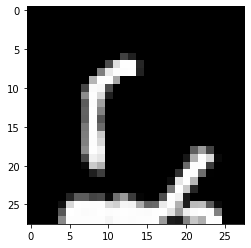

In [102]:
img = sample(model, img_shape=(1, 1, 28, 28))
print(img.shape)
plt.imshow(img.cpu().long().squeeze(), cmap="gray")
plt.show()

## Conditional PixelCNN

In [56]:
# import time
# import pathlib

# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.utils.data as data

# import torchvision
# import torchvision.transforms as T
# from torchvision.datasets import MNIST

In [57]:
# # hyperparameters
# NUM_EPOCHS = 50
# BATCH_SIZE = 32
# NUM_CHANNELS = 64
# LEARNING_RATE = 1e-3
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# train_dataset = MNIST(root='../datasets/', train=True, download=True, transform=T.ToTensor())
# test_dataset = MNIST(root='../datasets/', train=False, download=False, transform=T.ToTensor())

In [59]:
# train_dataloader = data.DataLoader(dataset=train_dataset, 
#                                    batch_size=BATCH_SIZE, 
#                                    shuffle=True, 
#                                    num_workers=2,
#                                    drop_last=True)
# test_dataloader = data.DataLoader(dataset=test_dataset, 
#                                    batch_size=BATCH_SIZE, 
#                                    shuffle=True, 
#                                    num_workers=2)

In [60]:
# class MaskedConvolution(nn.Module):
    
#     def __init__(self, in_channels, out_channels, mask, dilation=1):
#         super().__init__()
#         kernel_size = mask.shape
#         padding = tuple([dilation * (size-1)//2 for size in kernel_size])
#         self.conv = nn.Conv2d(in_channels=in_channels, 
#                               out_channels=out_channels, 
#                               kernel_size=kernel_size,
#                               padding=padding,
#                               dilation=dilation)
        
#         self.register_buffer('mask', mask)
    
#     def forward(self, x):
#         with torch.no_grad():
#             self.conv.weight = nn.Parameter(self.conv.weight * self.mask)
#         return self.conv(x)

In [61]:
# mask = torch.rand(3, 3)
# img = torch.randn(1, 1, 28, 28)
# mask_conv = MaskedConvolution(1, 32, mask, dilation=2)
# mask_conv(img).shape

In [62]:
# class VerticalStackConvolution(MaskedConvolution):
#     def __init__(self, in_channels, out_channels, kernel_size=3, mask_type='B', dilation=1):
#         assert mask_type in ['A', 'B']
#         mask = torch.ones(kernel_size, kernel_size)
#         mask[kernel_size//2+1:,:] = 0
#         if mask_type=='A':
#             mask[kernel_size//2,:] = 0
#         super().__init__(in_channels, out_channels, mask, dilation=dilation)
        
# class HorizontalStackConvolution(MaskedConvolution):
#     def __init__(self, in_channels, out_channels, kernel_size=3, mask_type='B', dilation=1):
#         assert mask_type in ['A', 'B']
#         mask = torch.ones(1, kernel_size)
#         mask[0, kernel_size//2+1:] = 0
#         if mask_type=='A':
#             mask[0, kernel_size//2] = 0
#         super().__init__(in_channels, out_channels, mask, dilation=dilation)

In [63]:
# test = VerticalStackConvolution(1, 32, 3)
# print(test.mask)
# test = VerticalStackConvolution(1, 32, 3, 'A')
# print(test.mask)
# test = HorizontalStackConvolution(1, 32, 3)
# print(test.mask)
# test = HorizontalStackConvolution(1, 32, 3, 'A')
# print(test.mask)
# del test

In [64]:
# class GatedConvolution(nn.Module):
#     def __init__(self, in_channels, kernel_size=3, dilation=1):
#         super().__init__()
#         self.encoded_label = nn.Embedding(num_embeddings=10, embedding_dim=in_channels*2)
        
#         self.v = VerticalStackConvolution(in_channels=in_channels,
#                                           out_channels=in_channels*2,
#                                           kernel_size=kernel_size,
#                                           dilation=dilation)
        
#         self.h = HorizontalStackConvolution(in_channels=in_channels,
#                                             out_channels=in_channels*2,
#                                             kernel_size=kernel_size,
#                                             dilation=dilation)
        
#         self.v_to_h = nn.Conv2d(in_channels=in_channels*2,
#                                 out_channels=in_channels*2,
#                                 kernel_size=1)
        
#         self.h_out = nn.Conv2d(in_channels=in_channels,
#                                out_channels=in_channels,
#                               kernel_size=1)
        
#     def forward(self, v_prev, h_prev, labels):
#         # condition image generation on the label
#         encoded_labels = self.encoded_label(labels).unsqueeze(2).unsqueeze(3)
        
#         v = self.v(v_prev)
#         v += encoded_labels
#         v_f, v_g = torch.chunk(v, chunks=2, dim=1)
#         v_out = torch.tanh(v_f) * torch.sigmoid(v_g)
        
#         h = self.h(h_prev)
#         h += encoded_labels
#         h += self.v_to_h(v)
#         h_f, h_g = torch.chunk(h, chunks=2, dim=1)
#         h_out = torch.tanh(h_f) * torch.sigmoid(h_g)
#         h_out = self.h_out(h_out)
#         h_out += h_prev
        
#         return v_out, h_out

In [65]:
# # test gated convolution
# gated = GatedConvolution(NUM_CHANNELS, dilation=2)
# v = torch.randn(1, NUM_CHANNELS, 28, 28)
# h = torch.randn(1, NUM_CHANNELS, 28, 28)
# labels = torch.randint(high=10, size=(1,))
# print(labels)
# v, h = gated(v, h, labels)
# print(v.shape, h.shape)
# del gated, v, h

In [66]:
# class GatedPixelCNN(nn.Module):
#     def __init__(self, hidden_channels, gated_config=[1, 2, 1, 4, 1, 2, 1]):
#         super().__init__()
#         self.v = VerticalStackConvolution(in_channels=1,
#                                           out_channels=hidden_channels,
#                                           kernel_size=7,
#                                           mask_type='A')
#         self.h = HorizontalStackConvolution(in_channels=1,
#                                           out_channels=hidden_channels,
#                                           kernel_size=7,
#                                           mask_type='A')
        
#         self.gated_convolutions = nn.ModuleList([GatedConvolution(hidden_channels, dilation=dilation) 
#                                                  for dilation in gated_config])
#         # later we apply a 256 way softmax
#         self.output = nn.Conv2d(in_channels=hidden_channels, 
#                                 out_channels=256,
#                                 kernel_size=1)
#     def forward(self, x, labels):
#         v = self.v(x)
#         h = self.h(x)
        
#         for gated_layer in self.gated_convolutions:
#             v, h = gated_layer(v, h, labels)
#         out = self.output(F.elu(h))
#         # from Batch, Classes, Height, Width to Batch, Classes, Channel, Height, Width
#         out = out.unsqueeze(dim=2)
#         return out

In [67]:
# test pixelcnn
# gated_pixel_cnn = GatedPixelCNN(NUM_CHANNELS)
# img = torch.randn(1, 1, 28, 28)
# label = torch.randint(high=10, size=(1,))
# output = gated_pixel_cnn(img, label)
# print(output.shape, labels.shape)

# labels = (torch.rand(1, 1, 28, 28) * 256).long()
# loss = F.cross_entropy(output, labels, reduction='mean')
# del gated_pixel_cnn, img, labels, output, loss

In [68]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# drive_path = pathlib.Path('/content/gdrive')
# weights_path = drive_path / 'MyDrive/weights'

In [69]:
# model = GatedPixelCNN(hidden_channels=NUM_CHANNELS).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99, verbose=True)

# # bits per dimension/pixel
# def criterion_fn(logits, labels):
#     nll = F.cross_entropy(logits, labels, reduction='none')
#     bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
#     return bpd.mean()

In [70]:
# # training loop
# best_loss = float("inf")
# scaler = torch.cuda.amp.GradScaler()
# for epoch in range(NUM_EPOCHS):
#     start_time = time.time()
#     train_losses = []
#     test_losses = []
#     for features, labels in train_dataloader:
#         optimizer.zero_grad()

#         features = features.to(DEVICE)
#         labels = labels.to(DEVICE)
#         images = (features * 255).long()

#         with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#           logits = model((features * 2) - 1, labels)
#           loss = criterion_fn(logits, images)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        
#         train_losses.append(loss.cpu().item())
        
#     # evaluate on the test dataset
#     with torch.inference_mode():
#         for features, labels in test_dataloader:
#             features = features.to(DEVICE)
#             labels = labels.to(DEVICE)
#             images = (features * 255).long()
#             with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
#               logits = model((features * 2) - 1, labels)
#               loss = criterion_fn(logits, images)
#             test_losses.append(loss.cpu().item())

#     end_time = time.time()
#     bpd_train = sum(train_losses)/len(train_losses)
#     bpd_test = sum(test_losses)/len(test_losses)
#     print(f'Elapsed Time: {end_time-start_time:.2f}sec, Epoch: {epoch+1}, BPD Train: {bpd_train:.4f}, BPD Test: {bpd_test:.4f}')
#     scheduler.step()
#     if bpd_test < best_loss:
#       print("Saving Weights")
#       best_loss = bpd_test
#       torch.save(model.state_dict(), f=weights_path / 'pixel_cnn_conditional.pt')

In [71]:
# # sample an image
# @torch.inference_mode()
# def sample(model, img_shape):
#     img = torch.zeros(img_shape, device=DEVICE) - 1
#     label = torch.tensor([1], device=DEVICE)
#     # Generation loop
#     _, channel, height, width = img_shape
#     for h in range(height):
#         for w in range(width):
#             for c in range(channel):
#                 pred = model((img[:,:,:h+1,:]/256 * 2) - 1, label)
#                 probs = F.softmax(pred[:,:,c,h,w], dim=-1)
#                 img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
#     return img

In [72]:
# img = sample(model, img_shape=(1, 1, 28, 28))
# print(img.shape)
# plt.imshow(img.cpu().long().squeeze(), cmap="gray")
# plt.show()